<a href="https://colab.research.google.com/github/PsorTheDoctor/microarray-data/blob/main/notebooks/microarray_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DCGAN: Generowanie mikromacierzy
##Import bibliotek

In [1]:
!git clone https://github.com/PsorTheDoctor/microarray-data.git
%cd microarray-data/

Cloning into 'microarray-data'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 155 (delta 50), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (155/155), 3.43 MiB | 4.10 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/microarray-data


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

from utils.load_data import load_data_by_label
from utils.augmentation import *

##Przygotowanie danych

In [53]:
IMG_SHAPE = (32, 32, 1)
BATCH_SIZE = 512

latent_dim = 128

(X_train, X_test) = load_data_by_label(label=1)
X = np.concatenate((X_train, X_test))

print(f'Number of examples: {len(X)}')
print(f'Shape of the images in the dataset: {X.shape[1:]}')

X = X.reshape(X.shape[0], *IMG_SHAPE).astype('float32')
# Konwersja do obrazów binarnych
# X = np.where(X < 0.5, 0, 1).astype('float32')

Number of examples: 471
Shape of the images in the dataset: (32, 32)


##Budowa dyskryminatora

In [47]:
def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def build_discriminator():
    img_input = layers.Input(shape=IMG_SHAPE)

    x = conv_block(
        img_input,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    discriminator = keras.models.Model(img_input, x, name='discriminator')
    return discriminator

discriminator = build_discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 16, 16, 64)        1664      
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 4, 4, 256)       

#Budowa generatora

In [48]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding='same',
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def build_generator():
    noise = layers.Input(shape=(latent_dim,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding='same',
        use_dropout=False
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding='same',
        use_dropout=False
    )
    x = upsample_block(
        x, 1, layers.Activation('tanh'), strides=(1, 1), use_bias=False, use_bn=True
    )
    # W tym momencie mamy wyjście w kształcie wejścia (32, 32, 1).
    generator = keras.models.Model(noise, x, name='generator')
    return generator

generator = build_generator()
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_11 (Dense)             (None, 4096)              524288    
_________________________________________________________________
batch_normalization_16 (Batc (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d_12 (UpSampling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 8, 8, 128)         29

##Nadpisanie kroku treningowego

In [49]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

##Trening modelu

In [11]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [ ]:
history = gan.fit(X, batch_size=BATCH_SIZE, epochs=50, verbose=2)

Text(0, 0.5, 'Strata')

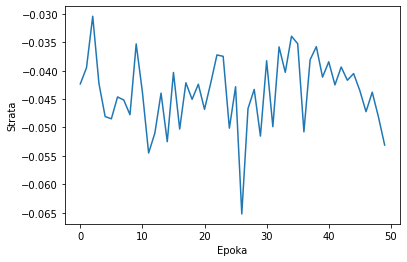

In [56]:
plt.plot(history.history['d_loss'])
plt.xlabel('Epoka')
plt.ylabel('Strata')

Text(0, 0.5, 'Strata')

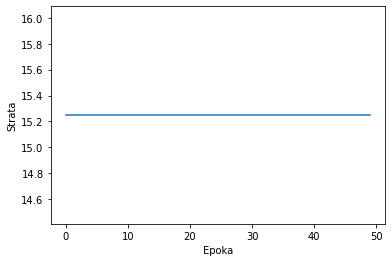

In [57]:
plt.plot(history.history['g_loss'])
plt.xlabel('Epoka')
plt.ylabel('Strata')

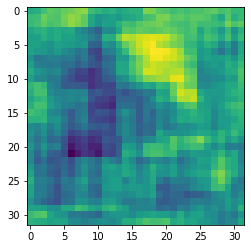

In [58]:
num_img = 1
latent_dim = 128

random_latent_vectors = tf.random.normal(shape=(num_img, latent_dim))
generated_images = generator(random_latent_vectors)
# generated_images = (generated_images * 127.5) + 127.5

# for i in range(num_img):
#   img = generated_images[i].numpy()
#   img = keras.preprocessing.image.array_to_img(img)

res = np.array(generated_images[0]).reshape((32, 32))

plt.imshow(res, cmap='viridis')